In [1]:
import argparse
parser = argparse.ArgumentParser()
# for training
parser.add_argument('--model_path', type=str, default='/media/arclabdl1/HD1/YLmiao/results/KMPnet_res/',help='path for saving trained models')
parser.add_argument('--model_dir', type=str, default='/media/arclabdl1/HD1/YLmiao/results/KMPnet_res/',help='path for saving trained models')
parser.add_argument('--no_env', type=int, default=100,help='directory for obstacle images')
parser.add_argument('--no_motion_paths', type=int,default=4000,help='number of optimal paths in each environment')
parser.add_argument('--no_val_paths', type=int,default=50,help='number of optimal paths in each environment')
parser.add_argument('--num_steps', type=int, default=200)


parser.add_argument('--seen_N', type=int, default=1)
parser.add_argument('--seen_NP', type=int, default=1)
parser.add_argument('--seen_s', type=int, default=1)
parser.add_argument('--seen_sp', type=int, default=1801)


# Model parameters
parser.add_argument('--total_input_size', type=int, default=8, help='dimension of total input')
parser.add_argument('--AE_input_size', type=int, default=32, help='dimension of input to AE')
parser.add_argument('--mlp_input_size', type=int , default=40, help='dimension of the input vector')
parser.add_argument('--output_size', type=int , default=1, help='dimension of the input vector')

parser.add_argument('--learning_rate', type=float, default=0.001)
parser.add_argument('--seen', type=int, default=0, help='seen or unseen? 0 for seen, 1 for unseen')
parser.add_argument('--device', type=int, default=3, help='cuda device')

parser.add_argument('--num_epochs', type=int, default=350)
parser.add_argument('--batch_size', type=int, default=100, help='rehersal on how many data (not path)')
parser.add_argument('--path_folder', type=str, default='./data/cartpole_obs/')
parser.add_argument('--path_file', type=str, default='path.pkl')

parser.add_argument('--start_epoch', type=int, default=350)
parser.add_argument('--env_type', type=str, default='cartpole_obs_4', help='environment')
parser.add_argument('--world_size', nargs='+', type=float, default=[30.0, 40.0, 3.141592653589793, 2.0], help='boundary of world')
parser.add_argument('--opt', type=str, default='Adagrad')
parser.add_argument('--direction', type=int, default=0, help='0: forward, 1: backward')
parser.add_argument('--loss', type=str, default='mse')

#parser.add_argument('--opt', type=str, default='Adagrad')
args = parser.parse_args('')
print(args)


Namespace(AE_input_size=32, batch_size=100, device=3, direction=0, env_type='cartpole_obs_4', learning_rate=0.001, loss='mse', mlp_input_size=40, model_dir='/media/arclabdl1/HD1/YLmiao/results/KMPnet_res/', model_path='/media/arclabdl1/HD1/YLmiao/results/KMPnet_res/', no_env=100, no_motion_paths=4000, no_val_paths=50, num_epochs=350, num_steps=200, opt='Adagrad', output_size=1, path_file='path.pkl', path_folder='./data/cartpole_obs/', seen=0, seen_N=1, seen_NP=1, seen_s=1, seen_sp=1801, start_epoch=350, total_input_size=8, world_size=[30.0, 40.0, 3.141592653589793, 2.0])


In [2]:
"""
This implements the Kinodynamic Planning using MPNet, by using MPNet
to generate random samples, that will guide the SST algorithm.
"""
import sys
sys.path.append('deps/sparse_rrt')
sys.path.append('.')
import torch
import torch.nn as nn
import model.AE.identity as cae_identity
from model.mlp import MLP
from model import mlp_acrobot, mlp_cartpole
from model.AE import CAE_acrobot_voxel_2d, CAE_acrobot_voxel_2d_2, CAE_acrobot_voxel_2d_3, CAE_cartpole_voxel_2d
from model.mpnet import KMPNet
from tools import data_loader
from tools.utility import *
from plan_utility import cart_pole, cart_pole_obs, pendulum, acrobot_obs

import numpy as np
import random
import os
from sparse_rrt import _sst_module

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import random




#global hl
if torch.cuda.is_available():
    torch.cuda.set_device(args.device)
# environment setting
cae = cae_identity
mlp = MLP
cpp_propagator = _sst_module.SystemPropagator()
if args.env_type == 'pendulum':
    normalize = pendulum.normalize
    unnormalize = pendulum.unnormalize
    system = standard_cpp_systems.PSOPTPendulum()
    dynamics = None
    enforce_bounds = None
    step_sz = 0.002
    num_steps = 20

elif args.env_type == 'cartpole':
    normalize = cart_pole.normalize
    unnormalize = cart_pole.unnormalize
    dynamics = cartpole.dynamics
    system = _sst_module.CartPole()
    enforce_bounds = cartpole.enforce_bounds
    step_sz = 0.002
    num_steps = 20
elif args.env_type == 'cartpole_obs':
    normalize = cart_pole_obs.normalize
    unnormalize = cart_pole_obs.unnormalize
    system = _sst_module.CartPole()
    dynamics = cartpole.dynamics
    enforce_bounds = cartpole.enforce_bounds
    step_sz = 0.002
    num_steps = 20
elif args.env_type == 'cartpole_obs_4':
    normalize = cart_pole_obs.normalize
    unnormalize = cart_pole_obs.unnormalize
    system = _sst_module.PSOPTCartPole()
    mlp = mlp_cartpole.MLP3_no_dropout
    cae = CAE_cartpole_voxel_2d
    dynamics = lambda x, u, t: cpp_propagator.propagate(system, x, u, t)
    enforce_bounds = cart_pole_obs.enforce_bounds
    step_sz = 0.002
    num_steps = 20
    obs_width = 4.0
    IsInCollision = cart_pole_obs.IsInCollision

elif args.env_type == 'acrobot_obs':
    normalize = acrobot_obs.normalize
    unnormalize = acrobot_obs.unnormalize
    system = _sst_module.PSOPTAcrobot()
    mlp = mlp_acrobot.MLP
    cae = CAE_acrobot_voxel_2d
    #dynamics = acrobot_obs.dynamics
    dynamics = lambda x, u, t: cpp_propagator.propagate(system, x, u, t)
    enforce_bounds = acrobot_obs.enforce_bounds
    step_sz = 0.02
    num_steps = 20
    obs_width = 6.0
    IsInCollision = acrobot_obs.IsInCollision
elif args.env_type == 'acrobot_obs_2':
    normalize = acrobot_obs.normalize
    unnormalize = acrobot_obs.unnormalize
    system = _sst_module.PSOPTAcrobot()
    mlp = mlp_acrobot.MLP2
    cae = CAE_acrobot_voxel_2d_2
    #dynamics = acrobot_obs.dynamics
    dynamics = lambda x, u, t: cpp_propagator.propagate(system, x, u, t)
    enforce_bounds = acrobot_obs.enforce_bounds
    step_sz = 0.02
    num_steps = 20
elif args.env_type == 'acrobot_obs_3':
    normalize = acrobot_obs.normalize
    unnormalize = acrobot_obs.unnormalize
    system = _sst_module.PSOPTAcrobot()
    mlp = mlp_acrobot.MLP3
    cae = CAE_acrobot_voxel_2d_2
    #dynamics = acrobot_obs.dynamics
    dynamics = lambda x, u, t: cpp_propagator.propagate(system, x, u, t)
    enforce_bounds = acrobot_obs.enforce_bounds
    step_sz = 0.02
    num_steps = 20
elif args.env_type == 'acrobot_obs_4':
    normalize = acrobot_obs.normalize
    unnormalize = acrobot_obs.unnormalize
    system = _sst_module.PSOPTAcrobot()
    mlp = mlp_acrobot.MLP3
    cae = CAE_acrobot_voxel_2d_3
    #dynamics = acrobot_obs.dynamics
    dynamics = lambda x, u, t: cpp_propagator.propagate(system, x, u, t)
    enforce_bounds = acrobot_obs.enforce_bounds
    step_sz = 0.02
    num_steps = 20
elif args.env_type == 'acrobot_obs_5':
    normalize = acrobot_obs.normalize
    unnormalize = acrobot_obs.unnormalize
    system = _sst_module.PSOPTAcrobot()
    mlp = mlp_acrobot.MLP
    cae = CAE_acrobot_voxel_2d_3
    #dynamics = acrobot_obs.dynamics
    dynamics = lambda x, u, t: cpp_propagator.propagate(system, x, u, t)
    enforce_bounds = acrobot_obs.enforce_bounds
    step_sz = 0.02
    num_steps = 20
elif args.env_type == 'acrobot_obs_6':
    normalize = acrobot_obs.normalize
    unnormalize = acrobot_obs.unnormalize
    system = _sst_module.PSOPTAcrobot()
    mlp = mlp_acrobot.MLP4
    cae = CAE_acrobot_voxel_2d_3
    #dynamics = acrobot_obs.dynamics
    dynamics = lambda x, u, t: cpp_propagator.propagate(system, x, u, t)
    enforce_bounds = acrobot_obs.enforce_bounds
    step_sz = 0.02
    num_steps = 20
elif args.env_type == 'acrobot_obs_7':
    normalize = acrobot_obs.normalize
    unnormalize = acrobot_obs.unnormalize
    system = _sst_module.PSOPTAcrobot()
    mlp = mlp_acrobot.MLP5
    cae = CAE_acrobot_voxel_2d_3
    #dynamics = acrobot_obs.dynamics
    dynamics = lambda x, u, t: cpp_propagator.propagate(system, x, u, t)
    enforce_bounds = acrobot_obs.enforce_bounds
    step_sz = 0.02
    num_steps = 20
elif args.env_type == 'acrobot_obs_8':
    normalize = acrobot_obs.normalize
    unnormalize = acrobot_obs.unnormalize
    system = _sst_module.PSOPTAcrobot()
    mlp = mlp_acrobot.MLP6
    cae = CAE_acrobot_voxel_2d_3
    #dynamics = acrobot_obs.dynamics
    dynamics = lambda x, u, t: cpp_propagator.propagate(system, x, u, t)
    enforce_bounds = acrobot_obs.enforce_bounds
    step_sz = 0.02
    num_steps = 20


# set loss for mpnet
if args.loss == 'mse':
    print('here')
    #mpnet.loss_f = nn.MSELoss()
    def mse_loss(y1, y2):
        l = (y1 - y2) ** 2
        l = torch.mean(l, dim=0)  # sum alone the batch dimension, now the dimension is the same as input dimension
        return l
    loss_f = mse_loss

elif args.loss == 'l1_smooth':
    #mpnet.loss_f = nn.SmoothL1Loss()
    def l1_smooth_loss(y1, y2):
        l1 = torch.abs(y1 - y2)
        cond = l1 < 1
        l = torch.where(cond, 0.5 * l1 ** 2, l1)
        l = torch.mean(l, dim=0)  # sum alone the batch dimension, now the dimension is the same as input dimension
    loss_f = l1_smooth_loss

elif args.loss == 'mse_decoupled':
    def mse_decoupled(y1, y2):
        # for angle terms, wrap it to -pi~pi
        l_0 = torch.abs(y1[:,0] - y2[:,0]) ** 2
        l_1 = torch.abs(y1[:,1] - y2[:,1]) ** 2
        l_2 = torch.abs(y1[:,2] - y2[:,2]) # angular dimension
        l_3 = torch.abs(y1[:,3] - y2[:,3]) ** 2

        cond = (l_2 > 1.0) * (l_2 <= 2.0)   # np.pi after normalization is 1.0
        l_2 = torch.where(cond, 2.0-l_2, l_2)
        l_2 = l_2 ** 2
        l_0 = torch.mean(l_0)
        l_1 = torch.mean(l_1)
        l_2 = torch.mean(l_2)
        l_3 = torch.mean(l_3)
        return torch.stack([l_0, l_1, l_2, l_3])
    loss_f = mse_decoupled



mpnet = KMPNet(args.total_input_size, args.AE_input_size, args.mlp_input_size, args.output_size, \
               cae, mlp, loss_f)
# load net
# load previously trained model if start epoch > 0
model_dir = args.model_dir
model_dir = model_dir+'cost_'+args.env_type+"_lr%f_%s_step_%d/" % (args.learning_rate, args.opt, args.num_steps)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model_path='cost_kmpnet_epoch_%d_direction_%d_step_%d.pkl' %(args.start_epoch, args.direction, args.num_steps)
torch_seed, np_seed, py_seed = 0, 0, 0
if args.start_epoch > 0:
    #load_net_state(mpnet, os.path.join(args.model_path, model_path))
    load_net_state(mpnet, os.path.join(model_dir, model_path))
    #torch_seed, np_seed, py_seed = load_seed(os.path.join(args.model_path, model_path))
    torch_seed, np_seed, py_seed = load_seed(os.path.join(model_dir, model_path))
    # set seed after loading
    torch.manual_seed(torch_seed)
    np.random.seed(np_seed)
    random.seed(py_seed)


if torch.cuda.is_available():
    mpnet.cuda()
    mpnet.mlp.cuda()
    mpnet.encoder.cuda()
    if args.opt == 'Adagrad':
        mpnet.set_opt(torch.optim.Adagrad, lr=args.learning_rate)
    elif args.opt == 'Adam':
        mpnet.set_opt(torch.optim.Adam, lr=args.learning_rate)
    elif args.opt == 'SGD':
        mpnet.set_opt(torch.optim.SGD, lr=args.learning_rate, momentum=0.9)
    elif args.opt == 'ASGD':
        mpnet.set_opt(torch.optim.ASGD, lr=args.learning_rate)

if args.start_epoch > 0:
    #load_opt_state(mpnet, os.path.join(args.model_path, model_path))
    load_opt_state(mpnet, os.path.join(model_dir, model_path))

# load train and test data
print('loading...')
seen_test_data = data_loader.load_test_dataset(args.seen_N, args.seen_NP,
                          args.path_folder, True, args.seen_s, args.seen_sp)
obc, obs, paths, sgs, path_lengths, controls, costs = seen_test_data
obc = obc.astype(np.float32)



pi = 0
pj = 0
new_obs_i = []
obs_i = obs[pi]
plan_res_env = []
plan_time_env = []
for k in range(len(obs_i)):
    obs_pt = []
    obs_pt.append(obs_i[k][0]-obs_width/2)
    obs_pt.append(obs_i[k][1]-obs_width/2)
    obs_pt.append(obs_i[k][0]-obs_width/2)
    obs_pt.append(obs_i[k][1]+obs_width/2)
    obs_pt.append(obs_i[k][0]+obs_width/2)
    obs_pt.append(obs_i[k][1]+obs_width/2)
    obs_pt.append(obs_i[k][0]+obs_width/2)
    obs_pt.append(obs_i[k][1]-obs_width/2)
    new_obs_i.append(obs_pt)
obs_i = new_obs_i



here
[32, 32]
torch.Size([1, 7, 7, 7])
length of the output of one encoder
343
loading...


In [3]:
delta = 0.025
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-4.0, 4.0, delta)

X, Y = np.meshgrid(x, y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2
print(Z.shape)


(320, 240)


[[6.802767  6.734728  6.5441613 ... 5.509368  5.8800454 5.692315 ]
 [6.788398  7.122897  6.517069  ... 6.25469   5.3400264 6.268491 ]
 [6.821313  6.7021685 6.6535683 ... 5.840359  6.0211153 5.9316115]
 ...
 [6.9334817 7.1738715 7.3718615 ... 9.131177  8.871589  8.721922 ]
 [7.3009973 7.422242  7.4273176 ... 8.913178  9.065625  8.998079 ]
 [7.5712447 7.5735035 7.640459  ... 9.162764  8.868302  9.023655 ]]
4.164628
9.793975
(60, 62)


/home/arclabdl1/YLmiao/kinodynamics/KinoMPNet/plan_utility/line_line_cc.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  uA = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / ((y4-y3)*(x2-x1) - (x4-x3)*(y2-y1))
/home/arclabdl1/YLmiao/kinodynamics/KinoMPNet/plan_utility/line_line_cc.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  uB = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / ((y4-y3)*(x2-x1) - (x4-x3)*(y2-y1))


feasible points
[[-30.           0.          -3.14159265   0.        ]
 [-30.           0.          -3.04159265   0.        ]
 [-30.           0.          -2.94159265   0.        ]
 ...
 [ 29.           0.           2.75840735   0.        ]
 [ 29.           0.           2.85840735   0.        ]
 [ 29.           0.           2.95840735   0.        ]]
infeasible points
[[-19.           0.           2.15840735   0.        ]
 [-19.           0.           2.25840735   0.        ]
 [-18.           0.           2.15840735   0.        ]
 ...
 [ 14.           0.          -0.54159265   0.        ]
 [ 14.           0.          -0.44159265   0.        ]
 [ 15.           0.          -1.04159265   0.        ]]


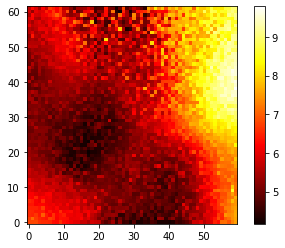

In [4]:

# on the entire state space, visualize the cost
# visualization
"""
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.set_autoscale_on(True)
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)
hl, = ax.plot([], [], 'b')
#hl_real, = ax.plot([], [], 'r')
hl_for, = ax.plot([], [], 'g')
hl_back, = ax.plot([], [], 'r')
hl_for_mpnet, = ax.plot([], [], 'lightgreen')
hl_back_mpnet, = ax.plot([], [], 'salmon')

#print(obs)
def update_line(h, ax, new_data):
    new_data = wrap_angle(new_data, propagate_system)
    h.set_data(np.append(h.get_xdata(), new_data[0]), np.append(h.get_ydata(), new_data[1]))
    #h.set_xdata(np.append(h.get_xdata(), new_data[0]))
    #h.set_ydata(np.append(h.get_ydata(), new_data[1]))

def remove_last_k(h, ax, k):
    h.set_data(h.get_xdata()[:-k], h.get_ydata()[:-k])

def draw_update_line(ax):
    #ax.relim()
    #ax.autoscale_view()
    fig.canvas.draw()
    fig.canvas.flush_events()
    #plt.show()

def wrap_angle(x, system):
    circular = system.is_circular_topology()
    res = np.array(x)
    for i in range(len(x)):
        if circular[i]:
            # use our previously saved version
            res[i] = x[i] - np.floor(x[i] / (2*np.pi))*(2*np.pi)
            if res[i] > np.pi:
                res[i] = res[i] - 2*np.pi
    return res
"""
dx = 1
dtheta = 0.1

imin = 0
imax = int(2*30./dx)
jmin = 0
jmax = int(2*np.pi/dtheta)


x0 = paths[pi][pj][0]
xT = paths[pi][pj][-1]
# visualize the cost on all grids

# randomly sample for several times
cost_sum_total = []
costmaps_total = []
cost_to_come_total = []
cost_to_goal_total = []
v_min_num = 20
costmaps = []
cost_to_come = []
cost_to_goal = []
for i in range(imin, imax):
    costmaps_i = []
    for j in range(jmin, jmax):
        for v_random_i in range(v_min_num):
            vdot1 = random.uniform(-40., 40.)
            vdot2 = random.uniform(-2., 2.)
            x = np.array([dx*i-30., vdot1, dtheta*j-np.pi, vdot2])
            cost_to_come_in = np.array([np.concatenate([x0, x])])
            cost_to_come_in = torch.from_numpy(cost_to_come_in).type(torch.FloatTensor)
            cost_to_come_in = normalize(cost_to_come_in, args.world_size).cuda()
            cost_to_goal_in = np.array([np.concatenate([x, xT])])
            cost_to_goal_in = torch.from_numpy(cost_to_goal_in).type(torch.FloatTensor)
            cost_to_goal_in = normalize(cost_to_goal_in, args.world_size).cuda()                
            cost_to_come.append(cost_to_come_in)
            cost_to_goal.append(cost_to_goal_in)
            # size: NixNjxN_random_i
cost_to_come = torch.cat(cost_to_come, 0)
cost_to_goal = torch.cat(cost_to_goal, 0)
obc_i_torch = torch.from_numpy(np.array([obc[pi]])).type(torch.FloatTensor).repeat(len(cost_to_goal), 1, 1, 1).cuda()
cost_sum = mpnet(cost_to_come, obc_i_torch) + mpnet(cost_to_goal, obc_i_torch)
cost_to_come_val = mpnet(cost_to_come, obc_i_torch).cpu().detach().numpy()[:,0]
cost_to_goal_val = mpnet(cost_to_goal, obc_i_torch).cpu().detach().numpy()[:,0]
cost_sum = cost_sum[:,0].cpu().detach().numpy()

# extract min from the cost
cost_sum = np.array(cost_sum).reshape(-1,v_min_num)
cost_sum = cost_sum.min(1)

cost_to_come_val = np.array(cost_to_come_val).reshape(-1,v_min_num)
cost_to_come_val = cost_to_come_val.min(1)

cost_to_goal_val = np.array(cost_to_goal_val).reshape(-1,v_min_num)
cost_to_goal_val = cost_to_goal_val.min(1)

cost_sum_2d = cost_sum.reshape(imax-imin,jmax-jmin)
for i in range(imin, imax):
    costmaps_i = []
    for j in range(jmin, jmax):
        costmaps_i.append(cost_sum_2d[i][j])
    costmaps.append(costmaps_i)
costmaps = np.array(costmaps)

#cost_to_come_val = cost_to_come_val
#cost_to_goal_val = cost_to_goal_val

cost_sum_total = cost_sum
costmaps_total = costmaps
cost_to_come_total = cost_to_come_val
cost_to_goal_total = cost_to_goal_val



cost_sum_total = cost_sum_total.reshape(-1)
#costmaps_total = np.array(costmaps_total).min(0)
cost_to_come_total = cost_to_come_total.reshape(-1)
cost_to_goal_total = cost_to_goal_total.reshape(-1)
    
    
cost_sum = cost_sum_total
costmaps = costmaps_total
cost_to_come_val = cost_to_come_total
cost_To_goal_val = cost_to_goal_total
# plot the costmap
print(costmaps)
print(costmaps.min())
print(costmaps.max())
#costmaps = costmaps - costmaps.min() + 1.0 # map to 1.0 to infty
#costmaps = np.log(costmaps)

print(costmaps.shape)
im = plt.imshow(costmaps.T, cmap='hot', interpolation='nearest', origin='lower')



   

dx = 1
dtheta = 0.1
feasible_points = []
infeasible_points = []
all_points = []
for i in range(imin, imax):
    for j in range(jmin, jmax):
        x = np.array([dx*i-30, 0., dtheta*j-np.pi, 0.])
        all_points.append(x)
        if IsInCollision(x, obs_i):
            infeasible_points.append(x)
        else:
            feasible_points.append(x)
            
all_points = np.array(all_points)
feasible_points = np.array(feasible_points)
infeasible_points = np.array(infeasible_points)
print('feasible points')
print(feasible_points)
print('infeasible points')
print(infeasible_points)
#ax.scatter(feasible_points[:,0], feasible_points[:,1], c='yellow')
#ax.scatter(infeasible_points[:,0], infeasible_points[:,1], c='pink')
#for i in range(len(data)):
#    update_line(hl, ax, data[i])
#draw_update_line(ax)
#state_t = start_state


plt.colorbar(im)
plt.show()



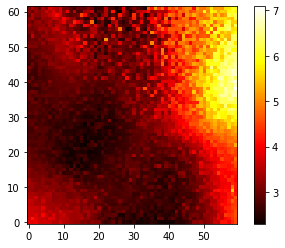

In [5]:
amplified_costmaps = np.exp(costmaps/5)
im = plt.imshow(amplified_costmaps.T, cmap='hot', interpolation='nearest', origin='lower')


plt.colorbar(im)
plt.show()


In [6]:
print(costmaps.shape)

(60, 62)


In [7]:
# propagate data
p_start = paths[pi][pj][0]
detail_paths = [p_start]
detail_controls = []
detail_costs = []
state = [p_start]
control = []
cost = []
for k in range(len(controls[pi][pj])):
    #state_i.append(len(detail_paths)-1)
    max_steps = int(costs[pi][pj][k]/step_sz)
    accum_cost = 0.
    #print('p_start:')
    #print(p_start)
    #print('data:')
    #print(paths[i][j][k])
    # modify it because of small difference between data and actual propagation
    p_start = paths[pi][pj][k]
    state[-1] = paths[pi][pj][k]
    for step in range(1,max_steps+1):
        p_start = dynamics(p_start, controls[pi][pj][k], step_sz)
        p_start = enforce_bounds(p_start)
        detail_paths.append(p_start)
        detail_controls.append(controls[pi][pj])
        detail_costs.append(step_sz)
        accum_cost += step_sz
        if (step % 1 == 0) or (step == max_steps):
            state.append(p_start)
            #print('control')
            #print(controls[i][j])
            control.append(controls[pi][pj][k])
            cost.append(accum_cost)
            accum_cost = 0.
#print('p_start:')
#print(p_start)
#print('data:')
#print(paths[i][j][-1])
state[-1] = paths[pi][pj][-1]
data = state
# end of propagation
data = np.array(data)

(3720,)
(3720,)


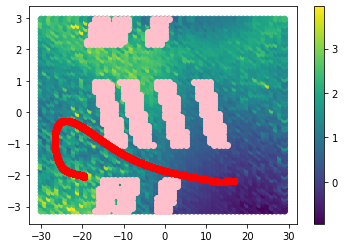

In [8]:
#ax.scatter(feasible_points[:,0], feasible_points[:,1], c='yellow')
print(all_points[:,0].shape)
print(all_points[:,2].shape)
cost_scat = plt.scatter(all_points[:,0], all_points[:,2], c=cost_to_goal_val)
plt.colorbar(cost_scat)

plt.scatter(infeasible_points[:,0], infeasible_points[:,2], c='pink')

plt.scatter(data[:,0], data[:,2], c='red')
plt.show()

(3720,)
(3720,)


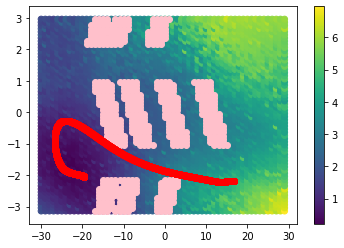

In [9]:
#ax.scatter(feasible_points[:,0], feasible_points[:,1], c='yellow')
print(all_points[:,0].shape)
print(all_points[:,2].shape)
cost_scat = plt.scatter(all_points[:,0], all_points[:,2], c=cost_to_come_val)
plt.colorbar(cost_scat)
plt.scatter(infeasible_points[:,0], infeasible_points[:,2], c='pink')

plt.scatter(data[:,0], data[:,2], c='red')
plt.show()

(3720,)
(3720,)
(3720,)


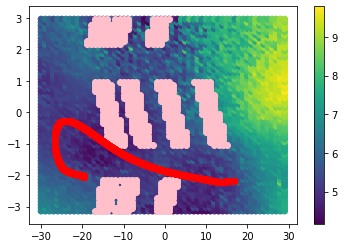

In [10]:
#ax.scatter(feasible_points[:,0], feasible_points[:,1], c='yellow')
print(all_points[:,0].shape)
print(all_points[:,2].shape)
print(cost_sum.shape)
cost_scat = plt.scatter(all_points[:,0], all_points[:,2], c=cost_sum)
plt.colorbar(cost_scat)
plt.scatter(infeasible_points[:,0], infeasible_points[:,2], c='pink')

plt.scatter(data[:,0], data[:,2], c='red')
plt.show()

(3720,)
(3720,)


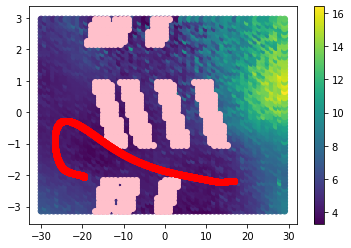

In [11]:
#ax.scatter(feasible_points[:,0], feasible_points[:,1], c='yellow')
amplified_cost_sum = np.exp(cost_sum/3.5)
print(all_points[:,0].shape)
print(all_points[:,2].shape)
cost_scat = plt.scatter(all_points[:,0], all_points[:,2], c=amplified_cost_sum)
plt.colorbar(cost_scat)
plt.scatter(infeasible_points[:,0], infeasible_points[:,2], c='pink')

plt.scatter(data[:,0], data[:,2], c='red')
plt.show()

In [12]:
data_cost_to_come = []
data_cost_to_goal = []
for i in range(len(data)):
    data_cost_to_come_i = np.array([np.concatenate([x0, data[i]])])
    data_cost_to_come_i = torch.from_numpy(data_cost_to_come_i).type(torch.FloatTensor)
    data_cost_to_come_i = normalize(data_cost_to_come_i, args.world_size).cuda()
    data_cost_to_goal_i = np.array([np.concatenate([data[i], xT])])
    data_cost_to_goal_i = torch.from_numpy(data_cost_to_goal_i).type(torch.FloatTensor)
    data_cost_to_goal_i = normalize(data_cost_to_goal_i, args.world_size).cuda()
    data_cost_to_come.append(data_cost_to_come_i)
    data_cost_to_goal.append(data_cost_to_goal_i)
data_cost_to_come = torch.cat(data_cost_to_come, 0)
data_cost_to_goal = torch.cat(data_cost_to_goal, 0)
obc_i_torch = torch.from_numpy(np.array([obc[pi]])).type(torch.FloatTensor).repeat(len(data_cost_to_come), 1, 1, 1).cuda()
data_cost_sum = mpnet(data_cost_to_come, obc_i_torch) + mpnet(data_cost_to_goal, obc_i_torch)
data_cost_to_come_val = mpnet(data_cost_to_come, obc_i_torch).cpu().detach().numpy()[:,0]
data_cost_to_goal_val = mpnet(data_cost_to_goal, obc_i_torch).cpu().detach().numpy()[:,0]
data_cost_sum = data_cost_sum[:,0].cpu().detach().numpy()
data_cost = np.cumsum(cost)




In [13]:
print("predicted cost_to_come:")
print(data_cost_to_come_val)
print("true cost_to_come:")
print(data_cost)

print("predicted cost_to_goal:")
print(data_cost_to_goal_val)
print("true cost_to_goal:")
print(np.sum(cost)-data_cost)


print("predicted added cost:")
print(data_cost_sum)
print("true added cost:")
print(np.sum(cost))


predicted cost_to_come:
[0.258584   0.25788394 0.25718328 ... 5.696051   5.701053   5.706044  ]
true cost_to_come:
[2.000e-03 4.000e-03 6.000e-03 ... 4.532e+00 4.534e+00 4.536e+00]
predicted cost_to_goal:
[5.706044   5.7042503  5.702458   ... 0.27230003 0.27103624 0.26976752]
true cost_to_goal:
[4.53400000e+00 4.53200000e+00 4.53000000e+00 ... 4.00000000e-03
 2.00000000e-03 2.77999845e-13]
predicted added cost:
[5.964628  5.9621344 5.959641  ... 5.9683514 5.9720893 5.975812 ]
true added cost:
4.5360000000000005


In [14]:
print("predicted cost_to_come loss:")
print(np.mean(np.abs(data_cost_to_come_val[1:] - data_cost)))
print("predicted cost_to_come loss:")
print(np.mean(np.abs(data_cost_to_goal_val[1:] - np.sum(cost) + data_cost)))
print("predicted cost_sum loss:")
print(np.mean(np.abs(data_cost_sum[1:] - np.sum(cost))))



predicted cost_to_come loss:
0.2907627860777298
predicted cost_to_come loss:
0.5838799929963426
predicted cost_sum loss:
0.7375835
